# Initialization and data loading

In [481]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), transforms.Normalize(0.5,0.5)])
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5,0.5)])


train_dataset = datasets.MNIST('./data', train=True, download=True,
                               transform=train_transforms)

x_train, y_train = train_dataset.data, train_dataset.targets

test_dataset = datasets.MNIST('./data', train=False, download=True,
                              transform=test_transforms)

x_test, y_test = test_dataset.data, test_dataset.targets


# Anomaly class selection


In [482]:
# TODO: choose a random class as anomalous and one as normal
n_classes = len(np.unique(y_train))
normal_class: int | None = 8  # Must be set to an integer
anomalous_class: int | None = 4  # Must be set to an integer

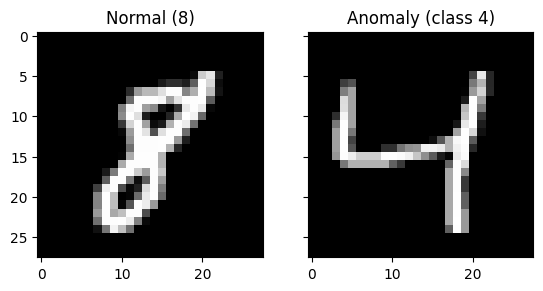

In [483]:
# print and log stuff
fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True)
ax[0].imshow(x_train[y_train == normal_class][0], cmap='gray')
ax[0].set_title(f"Normal ({normal_class})")
ax[1].imshow(x_train[y_train == anomalous_class][0], cmap='gray')
ax[1].set_title(f"Anomaly (class {anomalous_class})")
plt.show()

 # update train targets
train_dataset.data = x_train[y_train == normal_class]
train_dataset.targets = y_train[y_train == normal_class]

 # update test targets
test_dataset.data = x_test[(y_test == anomalous_class) | (y_test == normal_class)]
test_dataset.targets = y_test[(y_test == anomalous_class) | (y_test == normal_class)]
test_dataset.targets = test_dataset.targets == anomalous_class

# Define the model

In [484]:
BATCH_SIZE      = 32                # number of data points in each batch
N_EPOCHS        = 15                # times to run the model on complete data
INPUT_DIM       = 28 * 28           # size of each input
HIDDEN_DIM      = 256               # hidden dimension
LATENT_DIM      = 64                # latent vector dimension
lr              = 1e-2              # learning rate
noise_mean, noise_stddev = 0.0, 0.2 # parameters for denoising

In [485]:
class DeepDenoisingAutoencoder(nn.Module):

  def __init__(self):
    super(DeepDenoisingAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(INPUT_DIM, HIDDEN_DIM),
        nn.LeakyReLU(),
        nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
        nn.LeakyReLU(),
        nn.Linear(HIDDEN_DIM, LATENT_DIM),
    )
    self.decoder = nn.Sequential(
        nn.Linear(LATENT_DIM, HIDDEN_DIM),
        nn.LeakyReLU(),
        nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
        nn.LeakyReLU(),
        nn.Linear(HIDDEN_DIM, INPUT_DIM),
    )


  def forward(self, x: torch.Tensor):
    code = self.encoder(x)
    return self.decoder(code), code


# Model initialization

In [486]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=2)
testloader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=2)

In [487]:
model = DeepDenoisingAutoencoder()
opt = torch.optim.SGD(model.parameters(), lr)
criterion = nn.MSELoss()

In [488]:
@torch.no_grad()
def apply_noise(x: torch.Tensor):
  noise = torch.randn_like(x).to(x.device) * noise_stddev + noise_mean
  return x + noise

# Metrics computation

In [489]:
from sklearn import metrics

def compute_metrics(labels, preds):
    return metrics.roc_auc_score(labels, preds)

# Evaluation code

In [490]:
from tqdm import tqdm

def eval(model, testloader):
  model.eval()
  # Evaluate the model and return labels and predictions scores
  all_preds, all_labels = [], []
  with torch.no_grad():
    for x, y in tqdm(testloader, desc="Evaluation"):
      B, _, _, _ = x.shape
      x = x.view(B, -1)
      x.to(device)
      reconstructed, _ = model(x)
      error = (x-reconstructed).pow(2).mean(-1)
      all_labels.append(y)
      all_preds.append(error)

  all_labels = torch.hstack(all_labels).numpy()
  all_preds = torch.hstack(all_preds).numpy()

  return all_labels, all_preds


# Train

In [491]:
model = model.to(device)

for e in range(N_EPOCHS):
      running_loss = 0
      model.train()
      for i, (x, _) in enumerate(trainloader):
            opt.zero_grad()
            B, _, _, _ = x.shape
            x = x.view(B, -1)
            x.to(device)
            denoised, h = model(apply_noise(x))
            loss = criterion(denoised, x) + 0.5 * h.pow(2).mean()
            running_loss += loss.item()
            loss.backward()
            opt.step()

            if i % 100 == 99:
                print(f'Epoch: {e+1} , Iteration: {i+1}, Loss: {running_loss/100:.3f}')
                running_loss = 0.0

      all_labels, all_preds = eval(model, testloader)
      roc_auc = compute_metrics(all_labels, all_preds)
      print("Current ROC AUC: %.3f" % roc_auc)

Epoch: 1 , Iteration: 100, Loss: 0.915


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 95.85it/s] 

Current ROC AUC: 0.879


Epoch: 2 , Iteration: 100, Loss: 0.903


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 93.56it/s] 

Current ROC AUC: 0.888


Epoch: 3 , Iteration: 100, Loss: 0.892


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 92.30it/s] 

Current ROC AUC: 0.897


Epoch: 4 , Iteration: 100, Loss: 0.880


Evaluation: 100%|██████████| 62/62 [00:01<00:00, 58.74it/s]

Current ROC AUC: 0.905


Epoch: 5 , Iteration: 100, Loss: 0.867


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 94.49it/s] 

Current ROC AUC: 0.915


Epoch: 6 , Iteration: 100, Loss: 0.850


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 94.92it/s] 

Current ROC AUC: 0.925


Epoch: 7 , Iteration: 100, Loss: 0.825


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 71.42it/s]

Current ROC AUC: 0.925


Epoch: 8 , Iteration: 100, Loss: 0.778


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 67.73it/s]

Current ROC AUC: 0.847


Epoch: 9 , Iteration: 100, Loss: 0.656


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 94.71it/s] 

Current ROC AUC: 0.743


Epoch: 10 , Iteration: 100, Loss: 0.468


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 93.57it/s] 

Current ROC AUC: 0.729


Epoch: 11 , Iteration: 100, Loss: 0.360


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 93.23it/s] 

Current ROC AUC: 0.733


Epoch: 12 , Iteration: 100, Loss: 0.311


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 93.70it/s] 

Current ROC AUC: 0.735


Epoch: 13 , Iteration: 100, Loss: 0.289


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 94.44it/s] 

Current ROC AUC: 0.737


Epoch: 14 , Iteration: 100, Loss: 0.278


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 96.10it/s] 

Current ROC AUC: 0.739


Epoch: 15 , Iteration: 100, Loss: 0.271


Evaluation: 100%|██████████| 62/62 [00:00<00:00, 96.10it/s] 

Current ROC AUC: 0.739


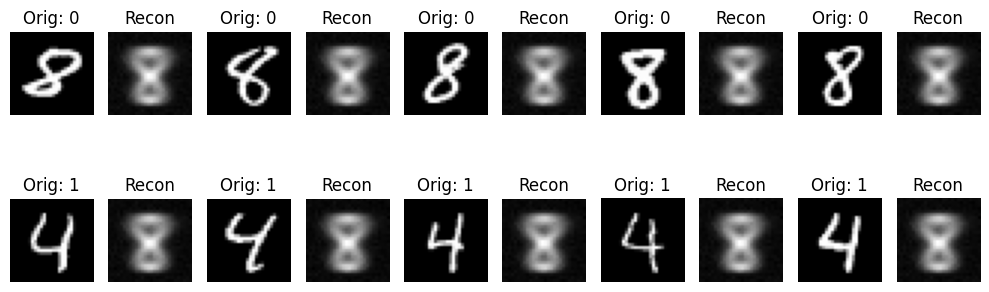

In [492]:
import matplotlib.pyplot as plt

def show_reconstructions(model, dataloader, device, classes=(0, 1), num_examples=5):
    model.eval()
    shown = {c: 0 for c in classes}
    fig, axs = plt.subplots(len(classes), 2 * num_examples, figsize=(2 * num_examples, len(classes)*2))

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x_flat = x.view(x.shape[0], -1)
            x_flat = apply_noise(x_flat)
            x_recon, h = model(x_flat)
            x_recon = x_recon.view_as(x)

            for i in range(x.size(0)):
                label = y[i].item()
                if label in classes and shown[label] < num_examples:
                    col = shown[label]
                    row = classes.index(label)
                    axs[row, col * 2].imshow(x[i].squeeze().cpu().numpy(), cmap='gray')
                    axs[row, col * 2].axis('off')
                    axs[row, col * 2].set_title(f"Orig: {label}")

                    axs[row, col * 2 + 1].imshow(x_recon[i].squeeze().cpu().numpy(), cmap='gray')
                    axs[row, col * 2 + 1].axis('off')
                    axs[row, col * 2 + 1].set_title("Recon")

                    shown[label] += 1

            if all(shown[c] >= num_examples for c in classes):
                break

    plt.tight_layout()
    plt.show()

show_reconstructions(model, testloader, device)